# step8: Correct ML Evaluation Pipeline with Fixed Cells
This notebook implements the **correct** workflow for detecting Low‑Rate DDoS (`DDoS‑SlowLoris`):
1. Split the original dataset into train/test.
2. Standardize only on training then apply to test.
3. Apply each augmentation method (SMOTE, ADASYN, CVAE, GAN) to *training only*.
4. Train ML models on augmented training data and evaluate on untouched test set.
5. Each model is in its own cell for clarity.


In [3]:
# 1. Imports, Data Load, Split, and Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from imblearn.over_sampling import SMOTE, ADASYN

# Load preprocessed data
df = pd.read_csv('preprocessed_CICIoT2023.csv')
print('Original data shape:', df.shape)

# Define candidate features (replace with full list)
candidate_features = [
    'flow_duration','Header_Length','Protocol Type','Duration','Rate',
    'Srate','Drate','fin_flag_number','syn_flag_number','rst_flag_number',
    'psh_flag_number','ack_flag_number','ece_flag_number','cwr_flag_number',
    'ack_count','syn_count','fin_count','urg_count','rst_count',
    'HTTP','HTTPS','DNS','Telnet','SMTP','SSH','IRC','TCP','UDP','DHCP',
    'ARP','ICMP','IPv','LLC','Tot sum','Min','Max','AVG','Std','Tot size',
    'IAT','Number','Magnitue','Radius','Covariance','Variance','Weight'
]

# Create binary target
df['is_low_rate'] = (df['label'] == 'DDoS-SlowLoris').astype(int)

# Split into train/test
X = df[candidate_features].values
y = df['is_low_rate'].values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print('Train shape:', X_train_raw.shape, 'Test shape:', X_test_raw.shape)
#print(df['label'].value_counts())
print('DDoS-SlowLoris count:', (df['label'] == 'DDoS-SlowLoris').sum())

print('Train positive:', (y_train == 1).sum())
print('Test positive:', (y_test == 1).sum())

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Control training data volume
sample_frac = 1.0  # fraction of train data per class

def sample_training(X, y, frac):
    if frac >= 1.0:
        return X, y
    idxs = []
    for c in np.unique(y):
        cidx = np.where(y == c)[0]
        n = int(len(cidx) * frac)
        idxs.append(np.random.choice(cidx, n, replace=False))
    idxs = np.concatenate(idxs)
    return X[idxs], y[idxs]

# Placeholder augmentation functions
def generate_cvae_samples(X_raw, y_raw, n_samples, target=1):
    # TODO: implement CVAE augmentation
    return np.empty((0, X_raw.shape[1])), np.empty((0,), dtype=int)

def generate_gan_samples(X_raw, y_raw, n_samples, target=1):
    # TODO: implement GAN augmentation
    return np.empty((0, X_raw.shape[1])), np.empty((0,), dtype=int)

sns.set(style='whitegrid')

Original data shape: (2366956, 47)
Train shape: (1656869, 46) Test shape: (710087, 46)
DDoS-SlowLoris count: 1176
Train positive: 823
Test positive: 353


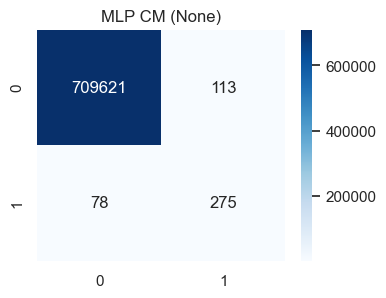

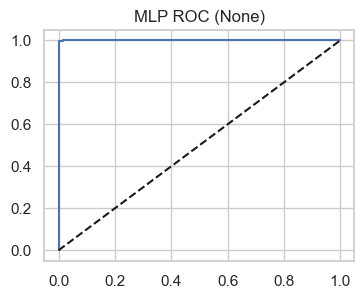

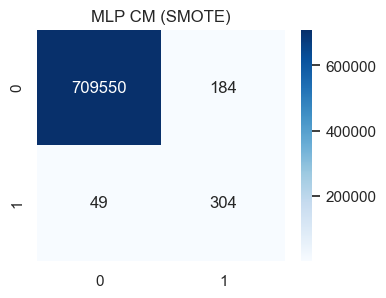

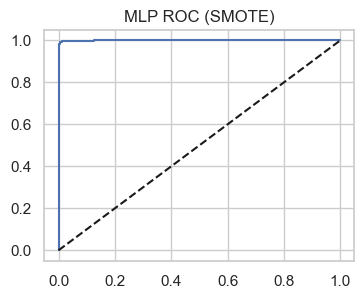

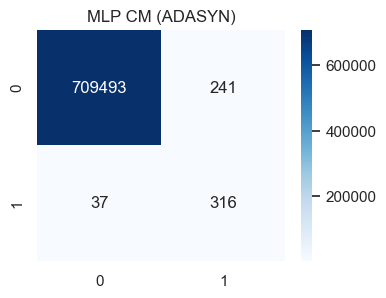

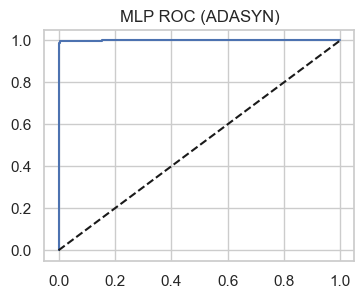

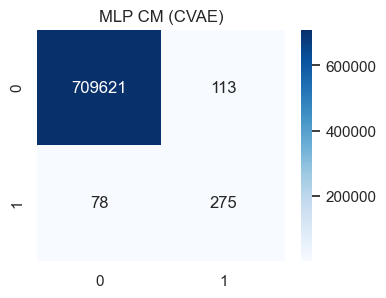

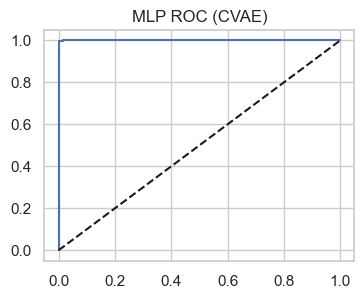

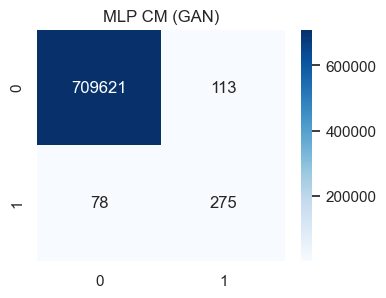

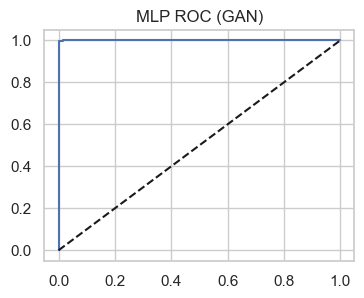

              Accuracy  Precision    Recall  F1-score       AUC
Augmentation                                                   
None          0.999731   0.708763  0.779037  0.742240  0.999771
SMOTE         0.999672   0.622951  0.861190  0.722949  0.999284
ADASYN        0.999608   0.567325  0.895184  0.694505  0.999116
CVAE          0.999731   0.708763  0.779037  0.742240  0.999771
GAN           0.999731   0.708763  0.779037  0.742240  0.999771


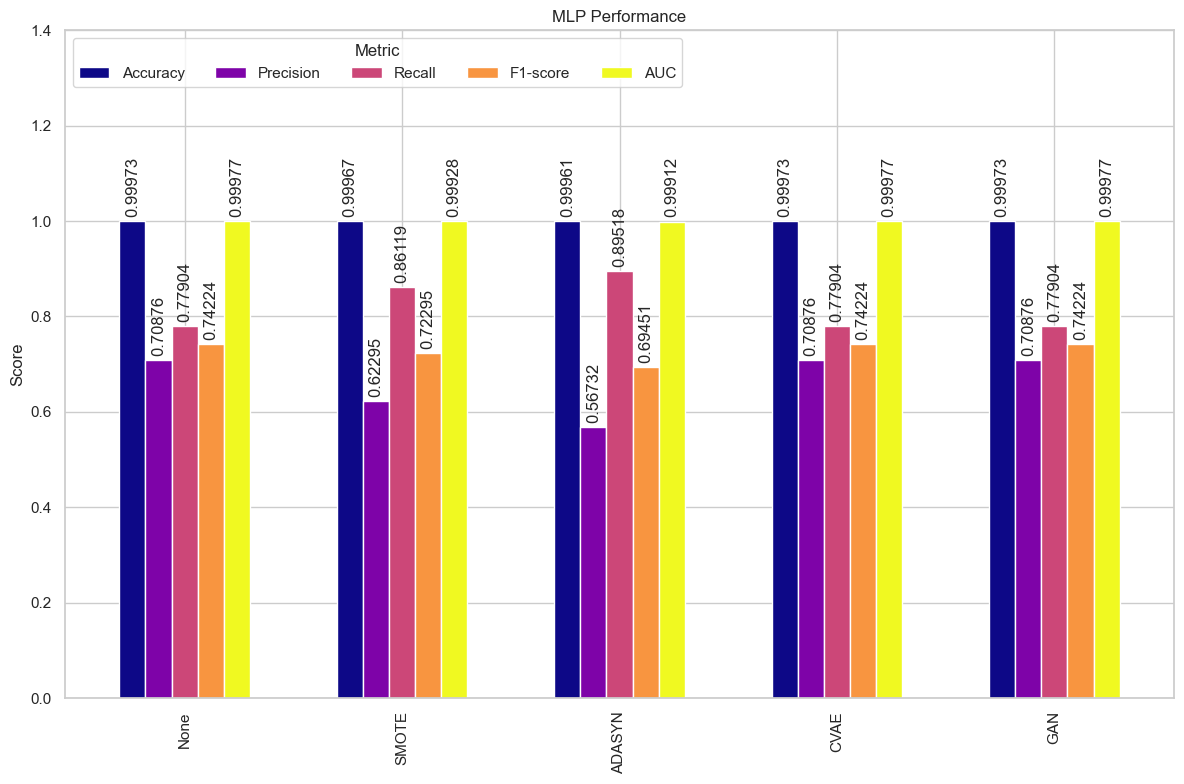

In [10]:
# Cell 2: Evaluate MLP
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=42, max_iter=500)
X_tr, y_tr = sample_training(X_train, y_train, sample_frac)

results = []
methods = ['None','SMOTE','ADASYN','CVAE','GAN']
for m in methods:
    if m == 'None':
        X_aug, y_aug = X_tr, y_tr
    elif m == 'SMOTE':
        X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'ADASYN':
        X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'CVAE':
        X_syn, y_syn = generate_cvae_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0)-sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_aug = np.vstack([X_tr, scaler.transform(X_syn)])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr
    else:  # GAN
        X_syn, y_syn = generate_gan_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0)-sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_aug = np.vstack([X_tr, scaler.transform(X_syn)])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr

    # Train & predict
    model.fit(X_aug, y_aug)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1] if hasattr(model,'predict_proba') else model.decision_function(X_test)

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    results.append({
        'Augmentation': m,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc_auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'MLP CM ({m})')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'MLP ROC ({m})')
    plt.show()

# Results table & enhanced bar chart for MLP
df_mlp = pd.DataFrame(results).set_index('Augmentation')
print(df_mlp)

fig, ax = plt.subplots(figsize=(12, 8))
df_mlp.plot.bar(colormap='plasma', ax=ax, width=0.6)

ax.set_title('MLP Performance')
ax.set_ylim(0, 1.4)
ax.set_ylabel('Score')
ax.set_xlabel('')

ax.legend(
    title='Metric',
    loc='upper left',
    ncol=5
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

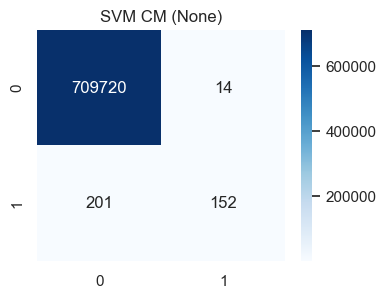

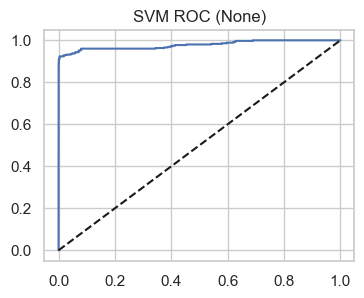

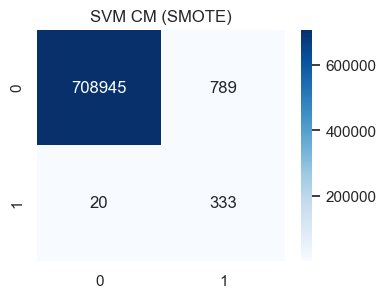

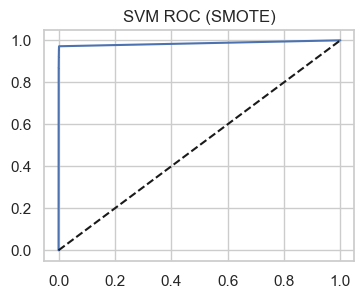

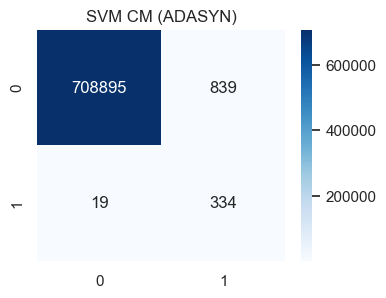

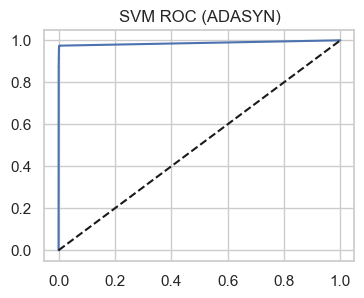

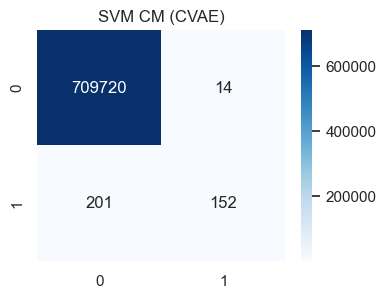

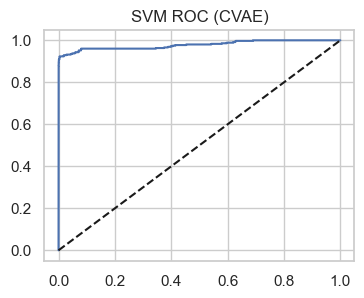

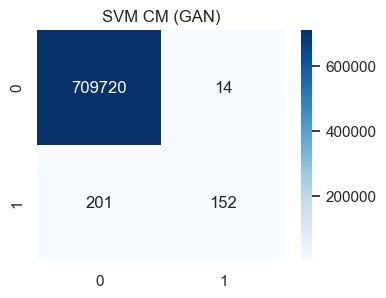

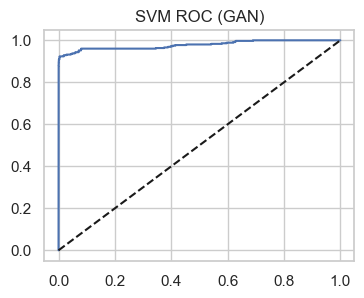

              Accuracy  Precision    Recall  F1-score       AUC
Augmentation                                                   
None          0.999697   0.915663  0.430595  0.585742  0.977802
SMOTE         0.998861   0.296791  0.943343  0.451525  0.985629
ADASYN        0.998792   0.284740  0.946176  0.437746  0.987025
CVAE          0.999697   0.915663  0.430595  0.585742  0.977802
GAN           0.999697   0.915663  0.430595  0.585742  0.977802


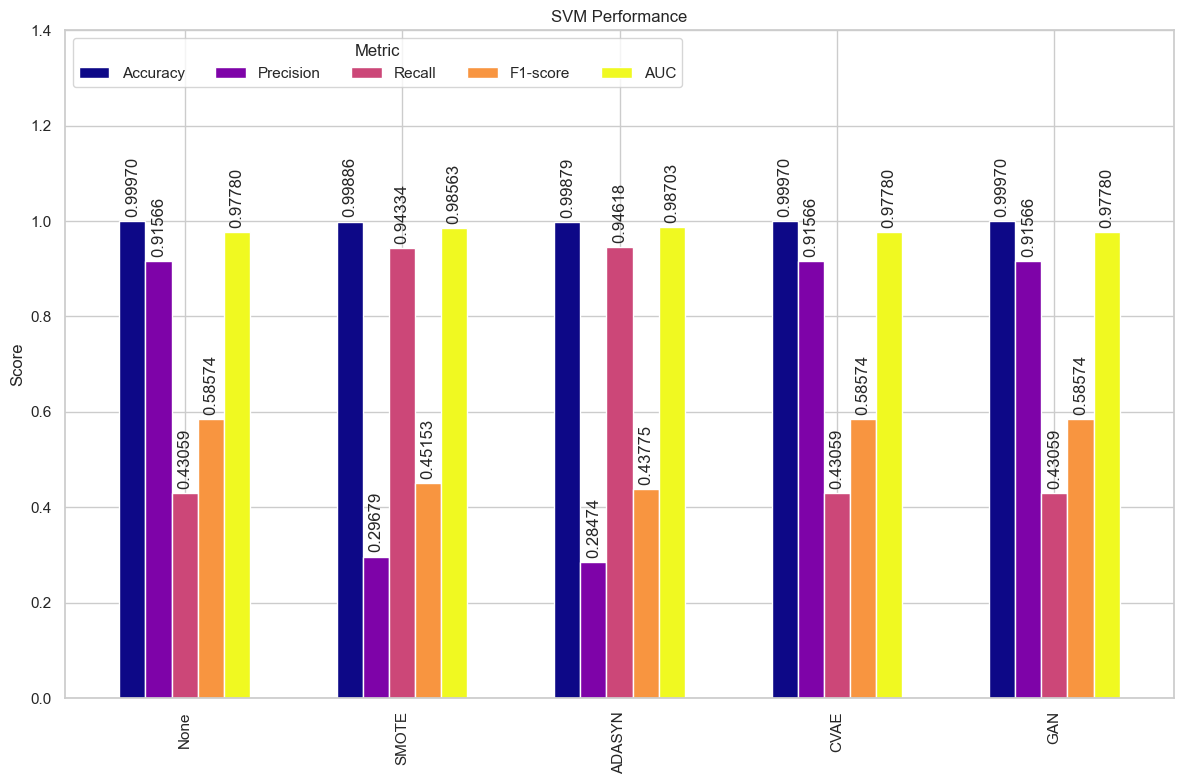

In [17]:
# Cell 3: Evaluate SVM with empty-augmentation safeguard
from sklearn.svm import SVC

model = SVC(probability=True, random_state=42)
X_tr, y_tr = sample_training(X_train, y_train, sample_frac)

results = []
methods = ['None', 'SMOTE', 'ADASYN', 'CVAE', 'GAN']
for m in methods:
    if m == 'None':
        X_aug, y_aug = X_tr, y_tr
    elif m == 'SMOTE':
        X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'ADASYN':
        X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'CVAE':
        X_syn, y_syn = generate_cvae_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_syn_scaled = scaler.transform(X_syn)
            X_aug = np.vstack([X_tr, X_syn_scaled])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr
    else:  # GAN
        X_syn, y_syn = generate_gan_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_syn_scaled = scaler.transform(X_syn)
            X_aug = np.vstack([X_tr, X_syn_scaled])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr

    # Train & predict
    model.fit(X_aug, y_aug)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    results.append({
        'Augmentation': m,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc_auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'SVM CM ({m})')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'SVM ROC ({m})')
    plt.show()

# Results table & enhanced bar chart for SVM
df_svm = pd.DataFrame(results).set_index('Augmentation')
print(df_svm)

fig, ax = plt.subplots(figsize=(12, 8))
df_svm.plot.bar(colormap='plasma', ax=ax, width=0.6)

ax.set_title('SVM Performance')
ax.set_ylim(0, 1.4)
ax.set_ylabel('Score')
ax.set_xlabel('')

ax.legend(
    title='Metric',
    loc='upper left',
    ncol=5
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

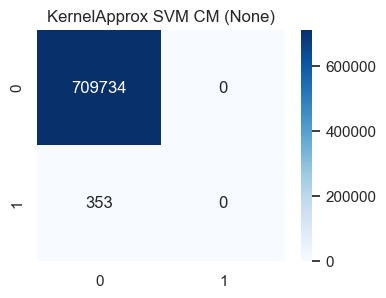

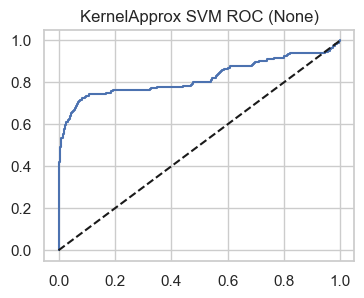

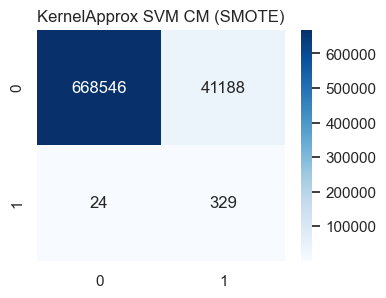

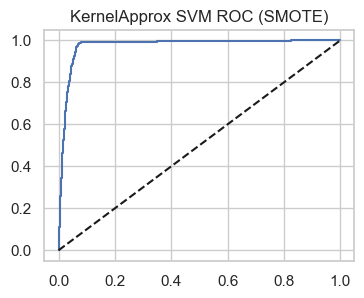

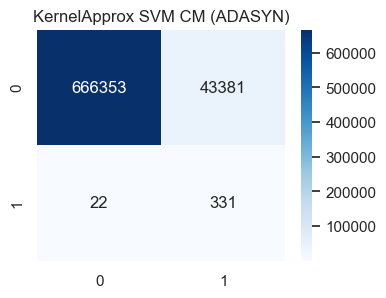

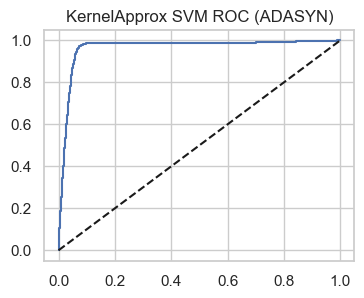

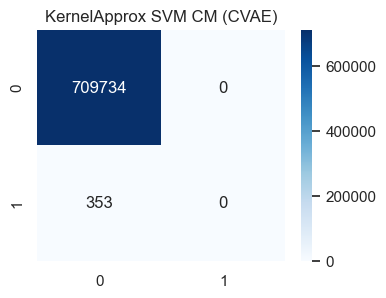

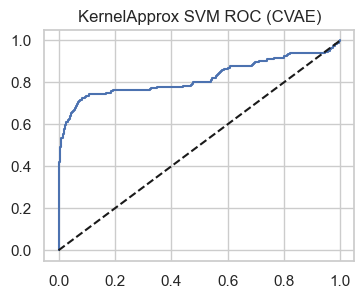

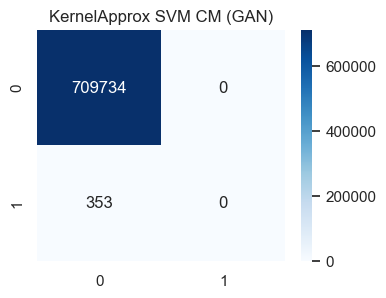

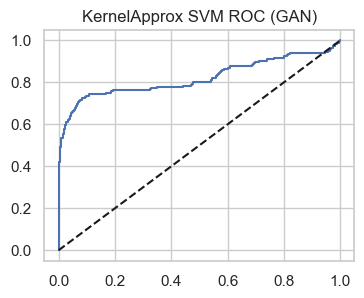

              Accuracy  Precision    Recall  F1-score       AUC
Augmentation                                                   
None          0.999503   0.000000  0.000000  0.000000  0.820769
SMOTE         0.941962   0.007924  0.932011  0.015715  0.973142
ADASYN        0.938877   0.007572  0.937677  0.015023  0.964603
CVAE          0.999503   0.000000  0.000000  0.000000  0.820769
GAN           0.999503   0.000000  0.000000  0.000000  0.820769


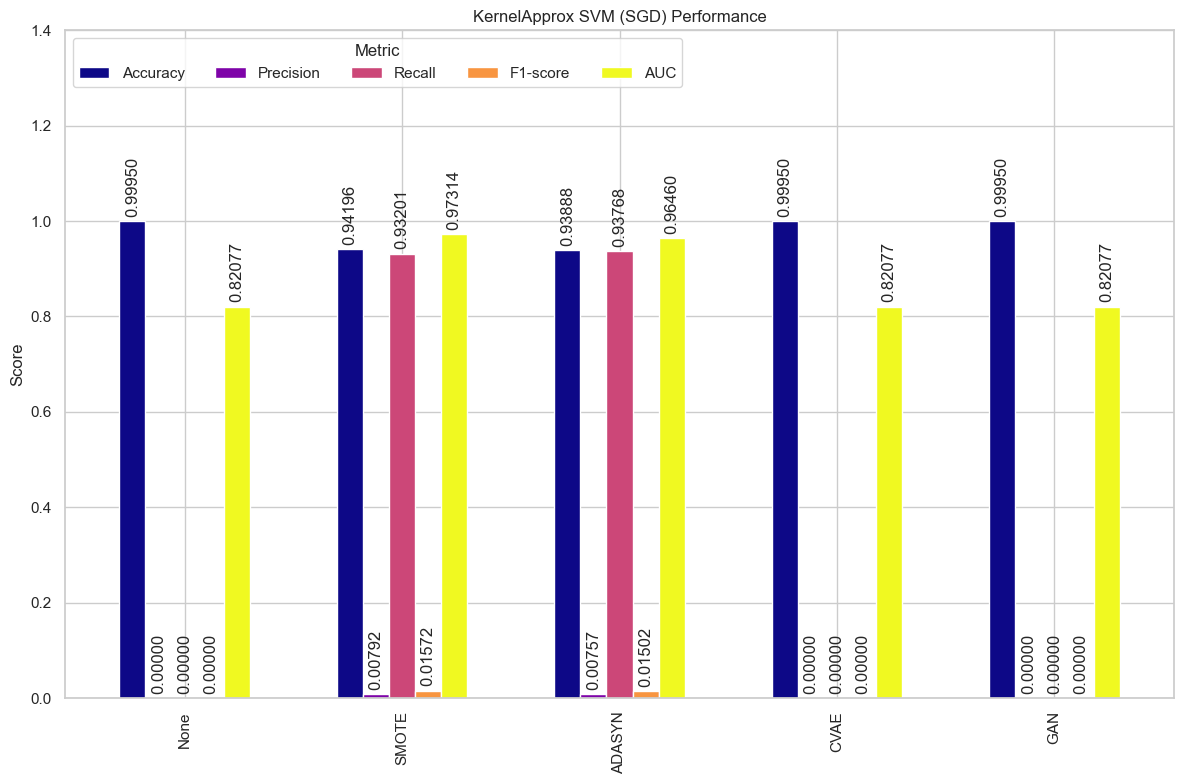

In [14]:
# Cell 3: Evaluate RBF‐Kernel Approximation + SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

# Build pipeline: approximate RBF kernel then linear hinge loss SGD
model = make_pipeline(
    RBFSampler(gamma=0.5, n_components=300, random_state=42),
    SGDClassifier(loss='hinge', random_state=42, max_iter=1000, tol=1e-3, n_jobs=-1)
)

# Sample training data
X_tr, y_tr = sample_training(X_train, y_train, sample_frac)

results = []
methods = ['None','SMOTE','ADASYN','CVAE','GAN']
for m in methods:
    if m == 'None':
        X_aug, y_aug = X_tr, y_tr
    elif m == 'SMOTE':
        X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'ADASYN':
        X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'CVAE':
        X_syn, y_syn = generate_cvae_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_aug = np.vstack([X_tr, scaler.transform(X_syn)])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr
    else:  # GAN
        X_syn, y_syn = generate_gan_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_aug = np.vstack([X_tr, scaler.transform(X_syn)])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr

    # Train & predict
    model.fit(X_aug, y_aug)
    y_pred = model.predict(X_test)
    # decision_function gives signed distance to hyperplane
    y_score = model.decision_function(X_test)

    # Compute metrics (safely handle zero-division)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred)  # recall is defined even if no positives predicted
    f1   = f1_score(y_test, y_pred, zero_division=0)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    results.append({
        'Augmentation': m,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc_auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'KernelApprox SVM CM ({m})')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'KernelApprox SVM ROC ({m})')
    plt.show()

# Results table & enhanced bar chart
df_kapprox = pd.DataFrame(results).set_index('Augmentation')
print(df_kapprox)

fig, ax = plt.subplots(figsize=(12, 8))
df_kapprox.plot.bar(colormap='plasma', ax=ax, width=0.6)

ax.set_title('KernelApprox SVM (SGD) Performance')
ax.set_ylim(0, 1.4)
ax.set_ylabel('Score')
ax.set_xlabel('')

ax.legend(
    title='Metric',
    loc='upper left',
    ncol=5
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

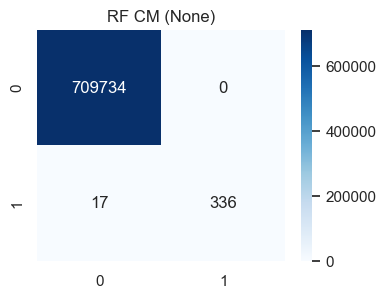

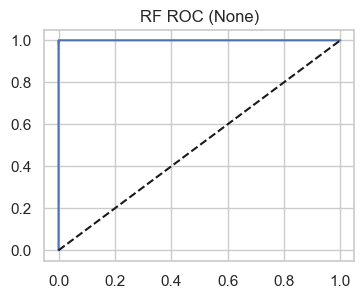

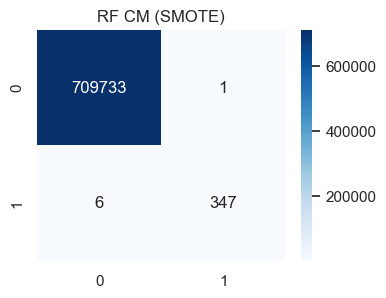

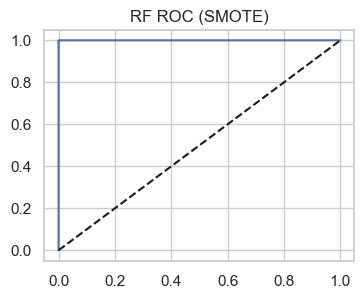

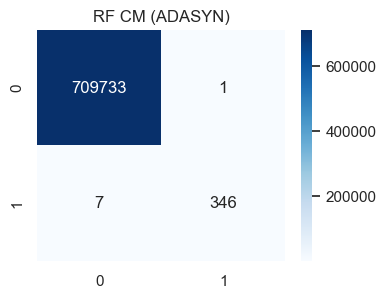

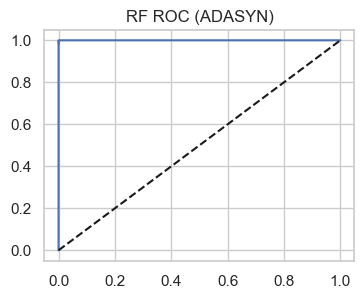

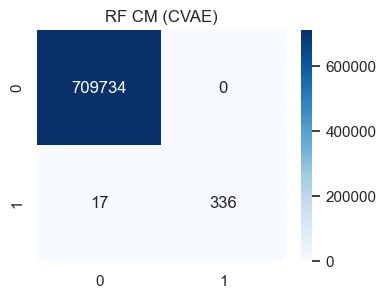

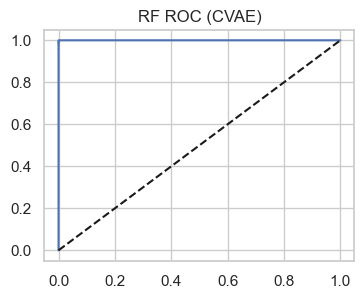

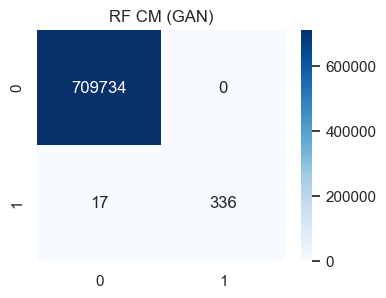

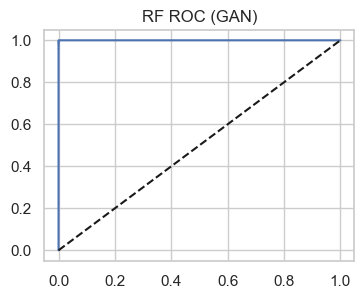

              Accuracy  Precision    Recall  F1-score       AUC
Augmentation                                                   
None          0.999976   1.000000  0.951841  0.975327  0.999999
SMOTE         0.999990   0.997126  0.983003  0.990014  1.000000
ADASYN        0.999989   0.997118  0.980170  0.988571  0.999999
CVAE          0.999976   1.000000  0.951841  0.975327  0.999999
GAN           0.999976   1.000000  0.951841  0.975327  0.999999


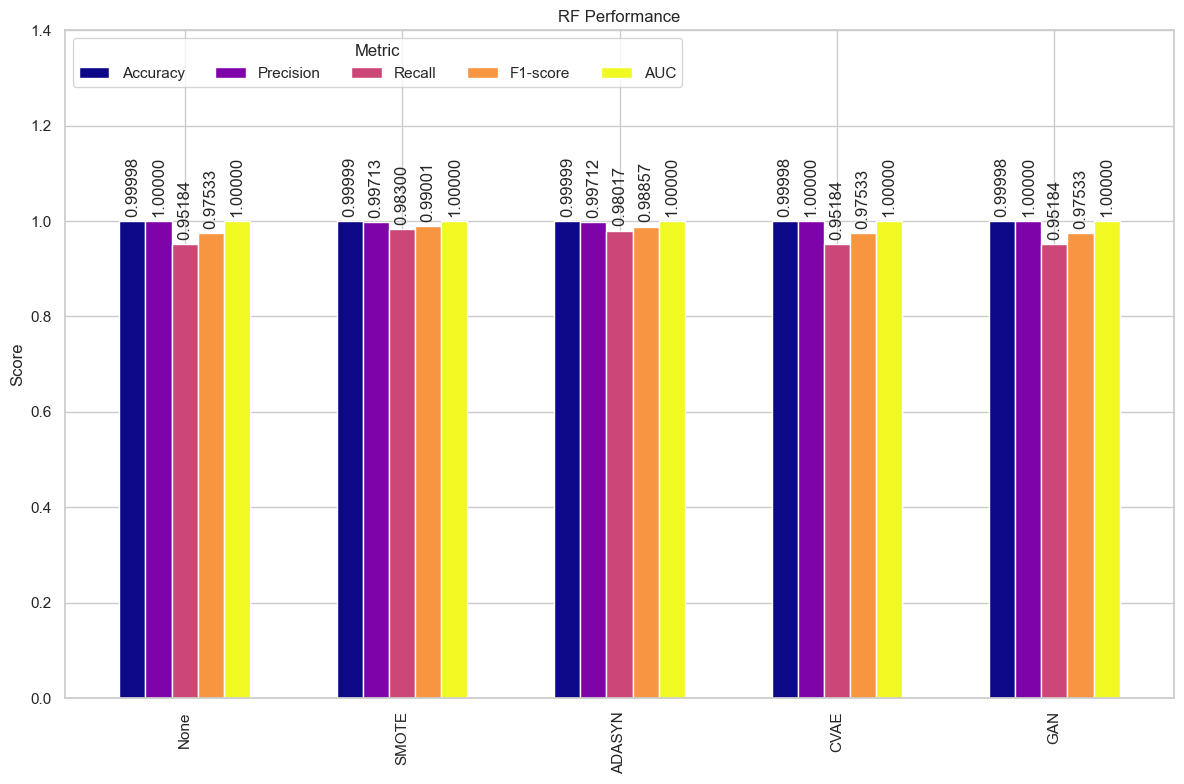

In [11]:
# Cell 4: Evaluate RandomForest with proper handling of empty synthetic arrays
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
X_tr, y_tr = sample_training(X_train, y_train, sample_frac)

results = []
methods = ['None', 'SMOTE', 'ADASYN', 'CVAE', 'GAN']
for m in methods:
    if m == 'None':
        X_aug, y_aug = X_tr, y_tr
    elif m == 'SMOTE':
        X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'ADASYN':
        X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'CVAE':
        X_syn, y_syn = generate_cvae_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_syn_scaled = scaler.transform(X_syn)
            X_aug = np.vstack([X_tr, X_syn_scaled])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr
    else:  # GAN
        X_syn, y_syn = generate_gan_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_syn_scaled = scaler.transform(X_syn)
            X_aug = np.vstack([X_tr, X_syn_scaled])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr

    # Train and predict
    model.fit(X_aug, y_aug)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1] if hasattr(model,'predict_proba') else model.decision_function(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    results.append({
        'Augmentation': m,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc_auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'RF CM ({m})')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'RF ROC ({m})')
    plt.show()

# Show results table and enhanced bar chart for RandomForest
df_rf = pd.DataFrame(results).set_index('Augmentation')
print(df_rf)

fig, ax = plt.subplots(figsize=(12, 8))
df_rf.plot.bar(colormap='plasma', ax=ax, width=0.6)

ax.set_title('RF Performance')
ax.set_ylim(0, 1.4)
ax.set_ylabel('Score')
ax.set_xlabel('')

ax.legend(
    title='Metric',
    loc='upper left',
    ncol=5
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

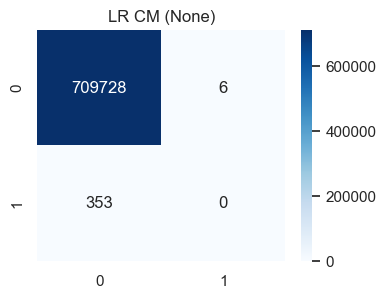

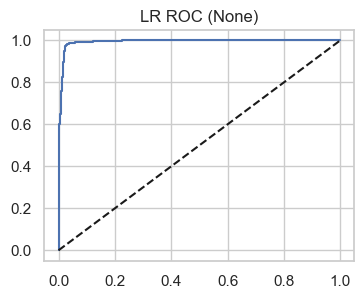

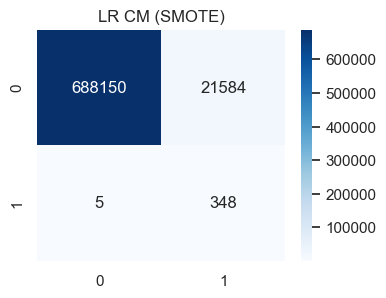

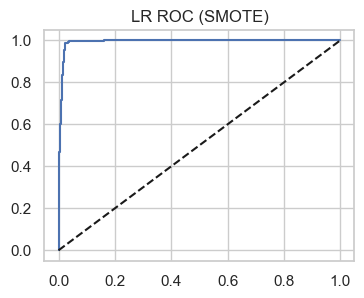

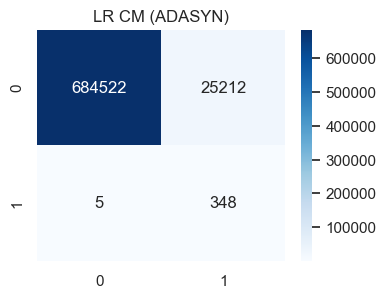

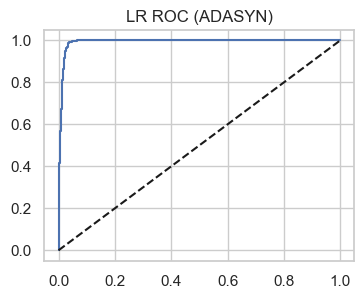

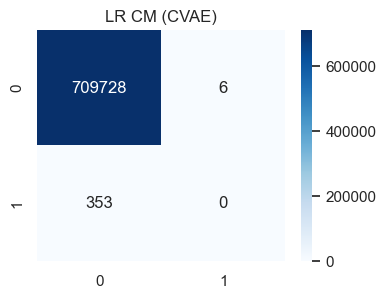

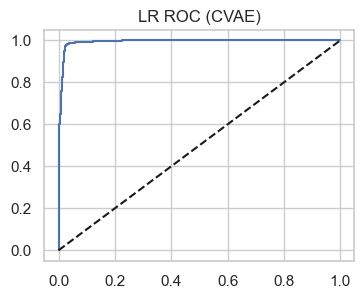

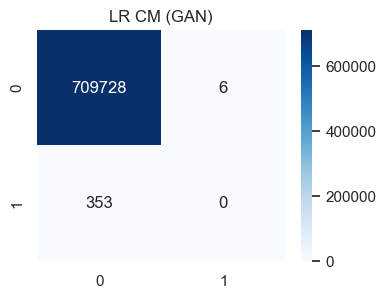

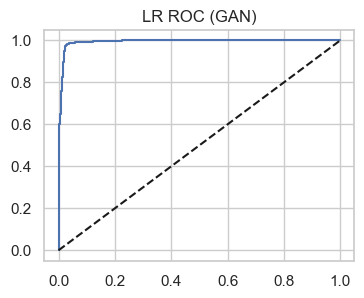

              Accuracy  Precision    Recall  F1-score       AUC
Augmentation                                                   
None          0.999494   0.000000  0.000000  0.000000  0.992696
SMOTE         0.969597   0.015867  0.985836  0.031232  0.992574
ADASYN        0.964487   0.013615  0.985836  0.026859  0.991638
CVAE          0.999494   0.000000  0.000000  0.000000  0.992696
GAN           0.999494   0.000000  0.000000  0.000000  0.992696


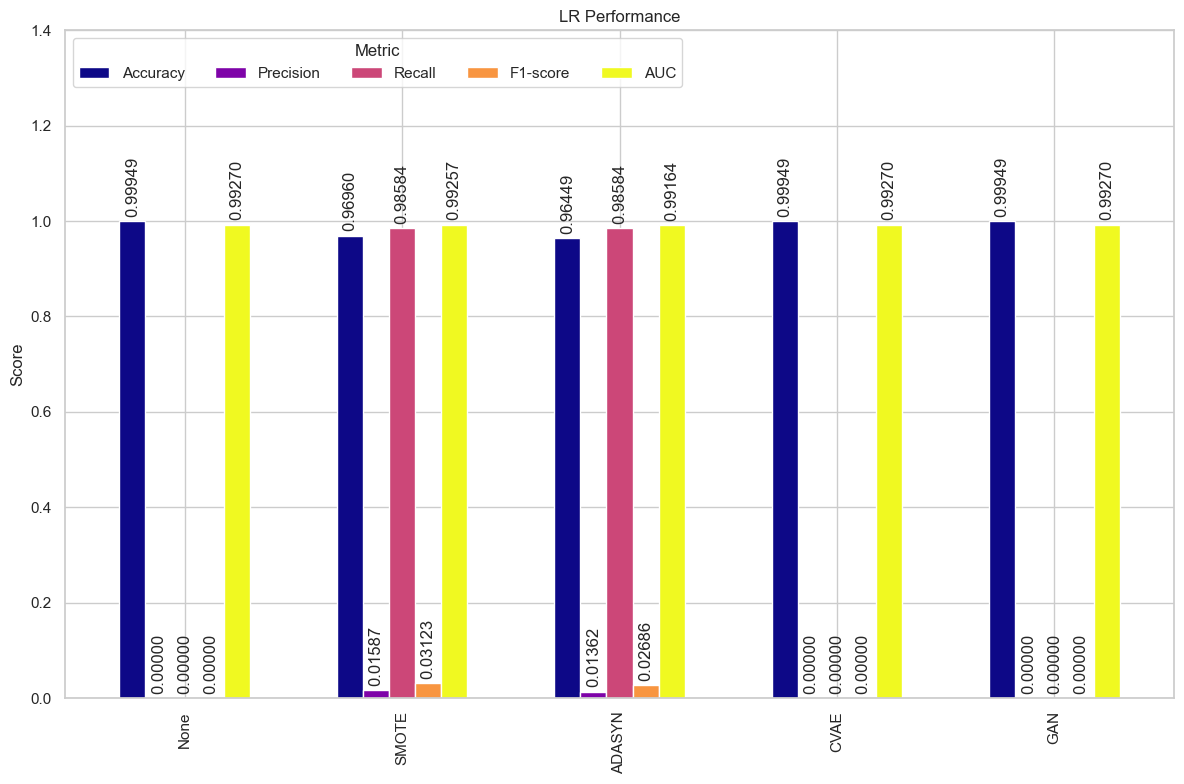

In [12]:
# Cell 5: Evaluate LogisticRegression with empty-augmentation safeguard
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42, max_iter=500)
X_tr, y_tr = sample_training(X_train, y_train, sample_frac)

results = []
methods = ['None', 'SMOTE', 'ADASYN', 'CVAE', 'GAN']
for m in methods:
    if m == 'None':
        X_aug, y_aug = X_tr, y_tr
    elif m == 'SMOTE':
        X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'ADASYN':
        X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'CVAE':
        X_syn, y_syn = generate_cvae_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_syn_scaled = scaler.transform(X_syn)
            X_aug = np.vstack([X_tr, X_syn_scaled])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr
    else:  # GAN
        X_syn, y_syn = generate_gan_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0) - sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_syn_scaled = scaler.transform(X_syn)
            X_aug = np.vstack([X_tr, X_syn_scaled])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr

    # Train & predict
    model.fit(X_aug, y_aug)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1] if hasattr(model,'predict_proba') else model.decision_function(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    results.append({
        'Augmentation': m,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc_auc
    })

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'LR CM ({m})')
    plt.show()

    # ROC Curve
    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'LR ROC ({m})')
    plt.show()

# Results table & enhanced bar chart for LogisticRegression
df_lr = pd.DataFrame(results).set_index('Augmentation')
print(df_lr)

fig, ax = plt.subplots(figsize=(12, 8))
df_lr.plot.bar(colormap='plasma', ax=ax, width=0.6)

ax.set_title('LR Performance')
ax.set_ylim(0, 1.4)
ax.set_ylabel('Score')
ax.set_xlabel('')

ax.legend(
    title='Metric',
    loc='upper left',
    ncol=5
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

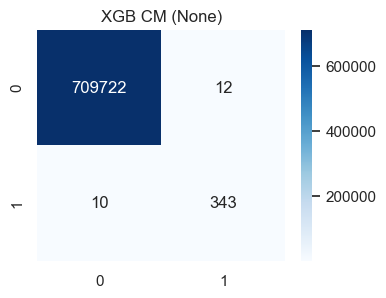

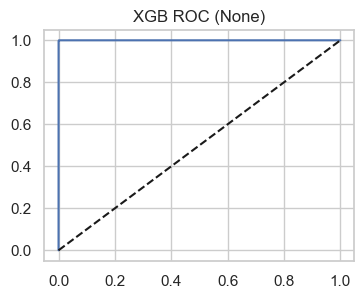

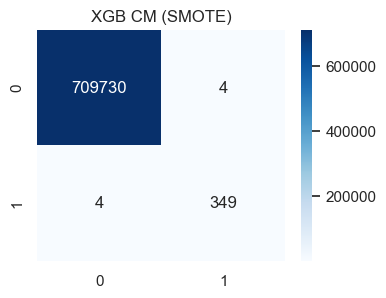

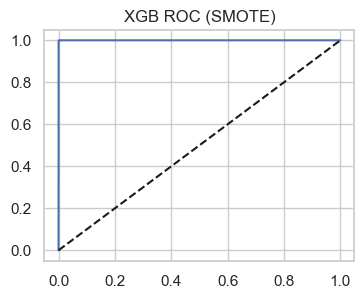

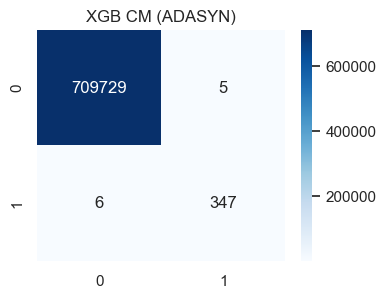

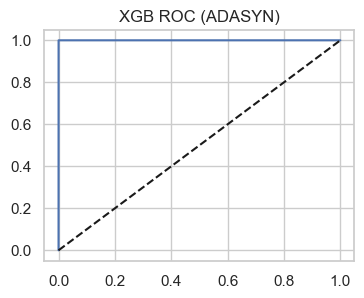

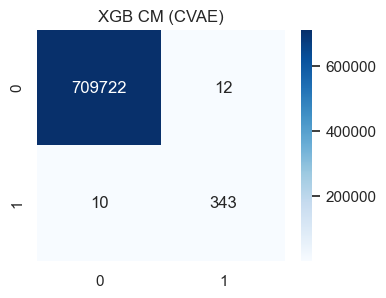

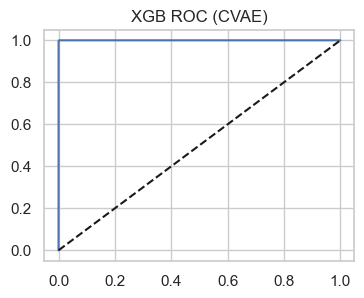

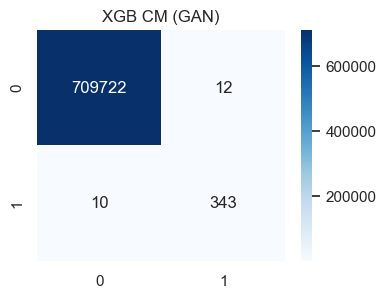

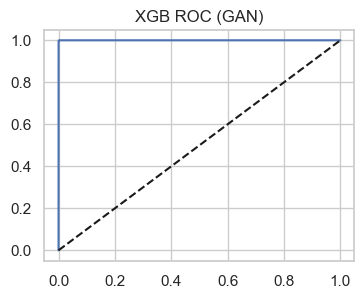

              Accuracy  Precision    Recall  F1-score       AUC
Augmentation                                                   
None          0.999969   0.966197  0.971671  0.968927  0.999992
SMOTE         0.999989   0.988669  0.988669  0.988669  0.999999
ADASYN        0.999985   0.985795  0.983003  0.984397  0.999999
CVAE          0.999969   0.966197  0.971671  0.968927  0.999992
GAN           0.999969   0.966197  0.971671  0.968927  0.999992


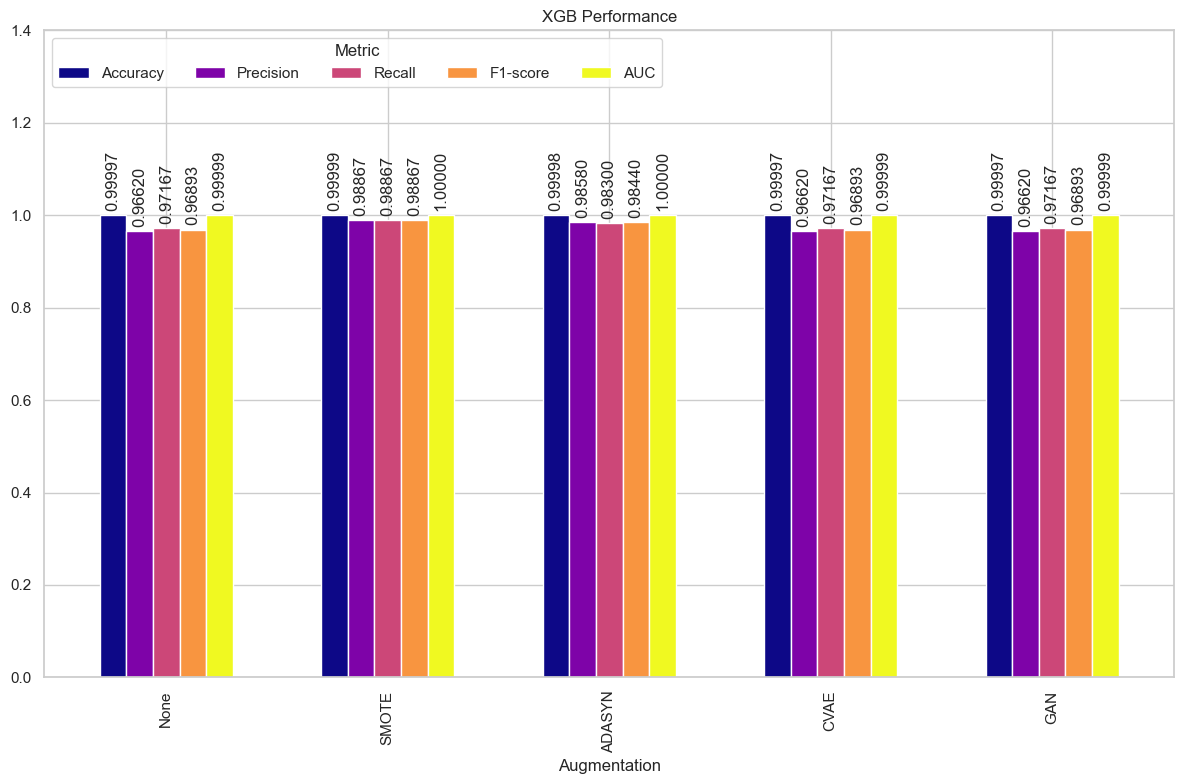

In [ ]:
# Cell 6: Evaluate XGBoost
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42, eval_metric='logloss')
X_tr, y_tr = sample_training(X_train, y_train, sample_frac)

results = []
methods = ['None','SMOTE','ADASYN','CVAE','GAN']
for m in methods:
    if m == 'None':
        X_aug, y_aug = X_tr, y_tr
    elif m == 'SMOTE':
        X_aug, y_aug = SMOTE(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'ADASYN':
        X_aug, y_aug = ADASYN(random_state=42).fit_resample(X_tr, y_tr)
    elif m == 'CVAE':
        X_syn, y_syn = generate_cvae_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0)-sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_aug = np.vstack([X_tr, scaler.transform(X_syn)])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr
    else:
        X_syn, y_syn = generate_gan_samples(
            X_train_raw, y_train,
            n_samples=(sum(y_train==0)-sum(y_train==1))
        )
        if X_syn.shape[0] > 0:
            X_aug = np.vstack([X_tr, scaler.transform(X_syn)])
            y_aug = np.concatenate([y_tr, y_syn])
        else:
            X_aug, y_aug = X_tr, y_tr

    model.fit(X_aug, y_aug)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1] if hasattr(model,'predict_proba') else model.decision_function(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    results.append({
        'Augmentation': m,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc_auc
    })

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'XGB CM ({m})')
    plt.show()

    plt.figure(figsize=(4,3))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title(f'XGB ROC ({m})')
    plt.show()

# After computing df_xgb:
df_xgb = pd.DataFrame(results).set_index('Augmentation')
print(df_xgb)

# Enhanced bar chart
fig, ax = plt.subplots(figsize=(12, 8))
df_xgb.plot.bar(colormap='plasma', ax=ax, width=0.6)

# Title and higher y-axis limit
ax.set_title('XGB Performance')
ax.set_ylim(0, 1.4)

# Legend horizontally below the title
ax.legend(
    title='Metric',
    loc='upper left',
    ncol= 5
)

# Annotate each bar with its value, rotated vertically
for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', rotation=90, padding=3)

plt.tight_layout()
plt.show()

## Consolidated Results Across All Models

,Augmentation,Accuracy,Precision,Recall,F1-score,AUC,Model
0,None,0.999731,0.708763,0.779037,0.742240,0.999771,MLP
1,SMOTE,0.999672,0.622951,0.861190,0.722949,0.999284,MLP
2,ADASYN,0.999608,0.567325,0.895184,0.694505,0.999116,MLP
3,CVAE,0.999731,0.708763,0.779037,0.742240,0.999771,MLP
4,GAN,0.999731,0.708763,0.779037,0.742240,0.999771,MLP
5,None,0.999697,0.915663,0.430595,0.585742,0.977802,SVM
6,SMOTE,0.998861,0.296791,0.943343,0.451525,0.985629,SVM
7,ADASYN,0.998792,0.284740,0.946176,0.437746,0.987025,SVM
8,CVAE,0.999697,0.915663,0.430595,0.585742,0.977802,SVM
9,GAN,0.999697,0.915663,0.430595,0.585742,0.977802,SVM


F1-score                                          \
Augmentation          ADASYN      CVAE       GAN      None     SMOTE   
Model                                                                  
KernelApprox-SGD    0.015023  0.000000  0.000000  0.000000  0.015715   
LogisticRegression  0.026859  0.000000  0.000000  0.000000  0.031232   
MLP                 0.694505  0.742240  0.742240  0.742240  0.722949   
RandomForest        0.988571  0.975327  0.975327  0.975327  0.990014   
SVM                 0.437746  0.585742  0.585742  0.585742  0.451525   
XGBoost             0.984397  0.968927  0.968927  0.968927  0.988669   

                         AUC                                          
Augmentation          ADASYN      CVAE       GAN      None     SMOTE  
Model                                                                 
KernelApprox-SGD    0.964603  0.820769  0.820769  0.820769  0.973142  
LogisticRegression  0.991638  0.992696  0.992696  0.992696  0.992574  
MLP                 0.999116  0.999771  0.999771  0.999771  0.999284  
RandomForest        0.999999  0.999999  0.999999  0.999999  1.000000  
SVM                 0.987025  0.977802  0.977802  0.977802  0.985629  
XGBoost             0.999999  0.999992  0.999992  0.999992  0.999999

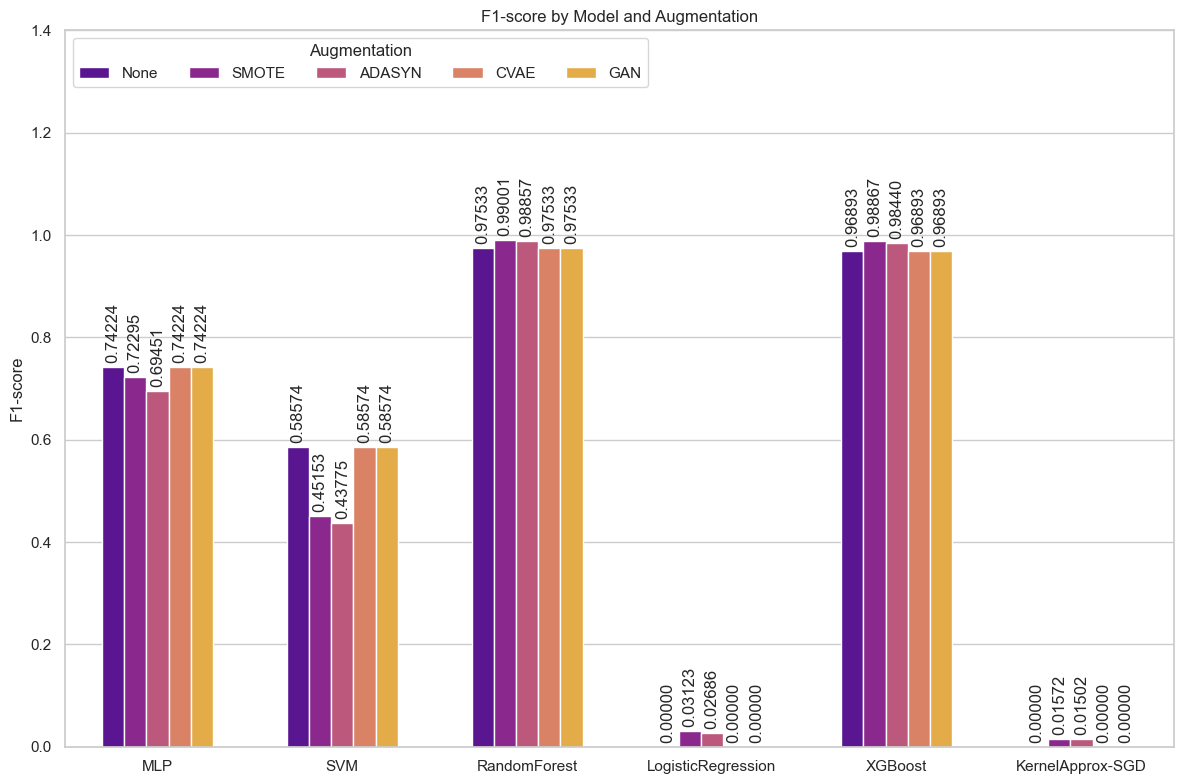

In [18]:
# Cell 7: Summary Comparison (including KernelApprox-SGD)
df_all = pd.concat([
    df_mlp.reset_index().assign(Model='MLP'),
    df_svm.reset_index().assign(Model='SVM'),
    df_rf.reset_index().assign(Model='RandomForest'),
    df_lr.reset_index().assign(Model='LogisticRegression'),
    df_xgb.reset_index().assign(Model='XGBoost'),
    df_kapprox.reset_index().assign(Model='KernelApprox-SGD')
], ignore_index=True)
display(df_all)

# Pivot for F1-score and AUC
pivot = df_all.pivot(index='Model', columns='Augmentation', values=['F1-score','AUC'])
display(pivot)

# F1-score comparison plot with value labels
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(
    data=df_all,
    x='Model',
    y='F1-score',
    hue='Augmentation',
    palette='plasma',
    ax=ax,
    width=0.6
)

ax.set_title('F1-score by Model and Augmentation')
ax.set_ylim(0, 1.4)
ax.set_ylabel('F1-score')
ax.set_xlabel('')

ax.legend(
    title='Augmentation',
    loc='upper left',
    ncol=len(df_all['Augmentation'].unique())
)

# Annotate each bar with its F1-score value (5 decimal places, vertical)
for container in ax.containers:
    ax.bar_label(container, fmt='%.5f', rotation=90, padding=3)

plt.tight_layout()
plt.show()